In [230]:
import pandas as pd
import sklearn
import numpy as np
import os
from scipy.optimize import curve_fit
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

In [6]:
print(files)

['optimus_56_K80.csv', 'optimus_32_P100.csv', 'optimus_26_k80.csv', 'optimus_50_P100.csv', 'optimus_50_K80.csv', 'optimus_20_V100.csv', 'optimus_32_V100.csv', 'optimus_20_P100.csv', 'optimus_44_V100.csv', 'optimus_20_K80.csv', 'optimus_44_K80.csv', 'optimus_56_V100.csv', 'optimus_26_P100.csv', 'optimus_26_V100.csv', 'optimus_56_P100.csv', 'optimus_32_k80.csv', 'optimus_50_V100.csv', 'optimus_44_P100.csv']


#### Helper functions

In [131]:
def fnc(l,k,b0,b1,b2):
    f = l-1/(b0*k+b1)-b2
    return f

def wrapped_fnc(obs, b0, b1, b2):
    l,k = obs
    return fnc(l,k,b0,b1,b2)

In [141]:
def sanity_check(l,params):
    b0, b1, b2 = params
    x = [i for i in range(len(l))]
    l_pred = [1/(b0*k + b1)+b2 for k in x]
    plt.plot(x,l)
    plt.plot(x,l_pred)
    plt.show()

#### Fit the data and get parameters b0, b1 and b2

In [175]:
all_params = np.empty((3))

files = os.listdir('model_data/')
files = sorted(files)
#files= ['optimus_56_K80.csv']
for file in files:
    if(file.endswith('.csv')):
        file = 'model_data/'+file
        #print(file)
        df = pd.read_csv(file)
        df.drop(df.tail(5).index, inplace=True)
        l = df['loss'].values
        k = df['step'].values
        xdata = np.vstack((l,k))
        ydata = np.zeros(l.shape)
        params, cov = curve_fit(wrapped_fnc,xdata,ydata,bounds=(0,np.inf))
        all_params = np.vstack((all_params,params))
    
#sanity_check() ## call with args l, parameters. Plots l vs l_pred

In [233]:
beta_df = pd.DataFrame({'b0':all_params[:,0], 'b1': all_params[:,1], 'b2': all_params[:,2]})[1:]
beta_df['GPU'] = ['K80','P100', 'V100','K80','P100', 'V100','K80','P100', 'V100','K80','P100', 'V100','K80','P100', 'V100']
beta_df['depth'] = [20,20,20,26,26,26,32,32,32,44,44,44,56,56,56]
beta_df = pd.concat([beta_df,pd.get_dummies(beta_df['GPU'])],axis=1)
print(beta_df)

x_pred = {'depth':[50,50,50], 'K80':[1,0,0], 'P100':[0,1,0], 'V100':[0,0,1]}
x_pred_df = pd.DataFrame(x_pred,columns=['depth','K80', 'V100', 'P100'])

          b0        b1        b2   GPU  depth  K80  P100  V100
1   0.000809  0.574052  0.202183   K80     20    1     0     0
2   0.000798  0.567968  0.198846  P100     20    0     1     0
3   0.000850  0.559622  0.202118  V100     20    0     0     1
4   0.000891  0.492385  0.228858   K80     26    1     0     0
5   0.000841  0.556948  0.229808  P100     26    0     1     0
6   0.000824  0.532168  0.226193  V100     26    0     0     1
7   0.000844  0.503837  0.249446   K80     32    1     0     0
8   0.000805  0.543303  0.245730  P100     32    0     1     0
9   0.000262  0.684735  0.040838  V100     32    0     0     1
10  0.000744  0.450322  0.251371   K80     44    1     0     0
11  0.000808  0.478097  0.281110  P100     44    0     1     0
12  0.000428  0.570911  0.145277  V100     44    0     0     1
13  0.000291  0.585948  0.107607   K80     56    1     0     0
14  0.000169  0.653758  0.005425  P100     56    0     1     0
15  0.000731  0.491864  0.293040  V100     56    0     

#### Make Predictions for resnet50

In [261]:
predicted_params = np.empty((1))

for param in ['b0','b1','b2']:
    x = beta_df[['depth','K80', 'P100', 'V100']]
    y = beta_df[[param]]
    model = Ridge()
    model.fit(x,y)
    y_pred = model.predict(x_pred_df)
    predicted_params = np.vstack((predicted_params,y_pred))

predicted_params = predicted_params[1:].reshape(3,3)
print(predicted_params)
## array structure: parameters are rows, GPUs are columns

[[5.43137200e-04 4.62532210e-04 5.16954755e-04]
 [5.25790356e-01 5.64583146e-01 5.58045235e-01]
 [1.82939894e-01 1.60939939e-01 1.69848644e-01]]


#### Load original data and compare

In [250]:
k80 = pd.read_csv('resnet50_data/optimus_50_K80.csv')
v100 = pd.read_csv('resnet50_data/optimus_50_V100.csv')
p100 = pd.read_csv('resnet50_data/optimus_50_P100.csv')

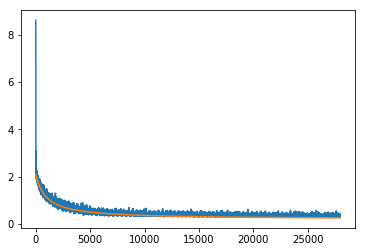

In [256]:
lk80 = k80['loss']
sanity_check(lk80, predicted_params[:,0])

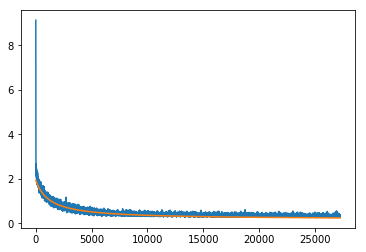

In [258]:
lp100 = p100['loss']
sanity_check(lp100, predicted_params[:,1])

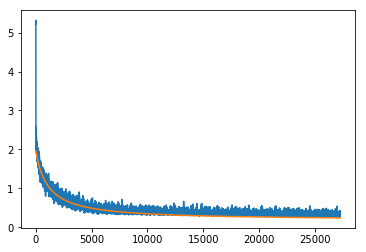

In [260]:
lv100 = v100['loss']
sanity_check(lv100, predicted_params[:,2])

## 4.3: Time vs Number of Workers

No. of steps per poch = 50000/128 = 391

No. of epochs to convergence = 85.

Parameters (as per table):
- $\theta_0$ = 1.02
- $\theta_1$ = 2.78
- $\theta_2$ = 4.92
- $\theta_3$ = 0.00
- $\theta_0$ = 0.02

To plot: Time taken to convergence vs Number of workers for Parameter servers in [1,2]

In [272]:
def ftime(w,p):
    theta_0 = 1.02
    theta_1 = 2.78
    theta_2 = 4.92
    theta_3 = 0.00
    theta_4 = 0.02
    return 391*85/(theta_0*128/w + theta_1 + theta_2*w/p + theta_3*w + theta_4*p)

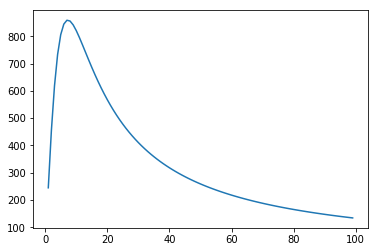

In [273]:
# 2 parameter servers

w = [w for w in range(1,100)]
time_2 = [ftime(nw,2) for nw in w]
plt.plot(w,time_2)
plt.show()

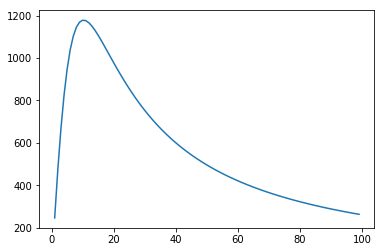

In [274]:
# 4 parameter servers

time_4 = [ftime(nw,4) for nw in w]
plt.plot(w,time_4)
plt.show()